In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=17d9238345f091554afd2f52984ea50338da39912fb456f1795dd0c7cfd97bf6
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


# importing necessary packages and library

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from wordcloud import WordCloud

In [3]:
spark = SparkSession.builder \
    .appName("TSVImportExample") \
    .getOrCreate()


In [4]:
amazon_review = "/content/amazon_alexa.tsv"

# Reading the TSV file into a DataFrame
df = spark.read \
    .option("delimiter", "\t") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(amazon_review)


In [5]:
df.show()

+------+---------+--------------------+--------------------+--------+
|rating|     date|           variation|    verified_reviews|feedback|
+------+---------+--------------------+--------------------+--------+
|     5|31-Jul-18|    Charcoal Fabric |       Love my Echo!|       1|
|     5|31-Jul-18|    Charcoal Fabric |           Loved it!|       1|
|     4|31-Jul-18|      Walnut Finish |Sometimes while p...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I have had a lot ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |               Music|       1|
|     5|31-Jul-18|Heather Gray Fabric |I received the ec...|       1|
|     3|31-Jul-18|   Sandstone Fabric |Without having a ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I think this is t...|       1|
|     5|30-Jul-18|Heather Gray Fabric |         looks great|       1|
|     5|30-Jul-18|Heather Gray Fabric |Love it! I’ve lis...|       1|
|     5|30-Jul-18|    Charcoal Fabric |I sent it to my 8...|       1|
|     5|30-Jul-18|  

# Converting the Spark DataFrame to a Pandas DataFrame

In [6]:
pandas_df = df.toPandas()

# Group by rating and count the number of reviews for each rating

In [7]:
rating_counts = pandas_df.groupby('rating').size().reset_index(name='count')

# Plotting the customer behavior based on ratings

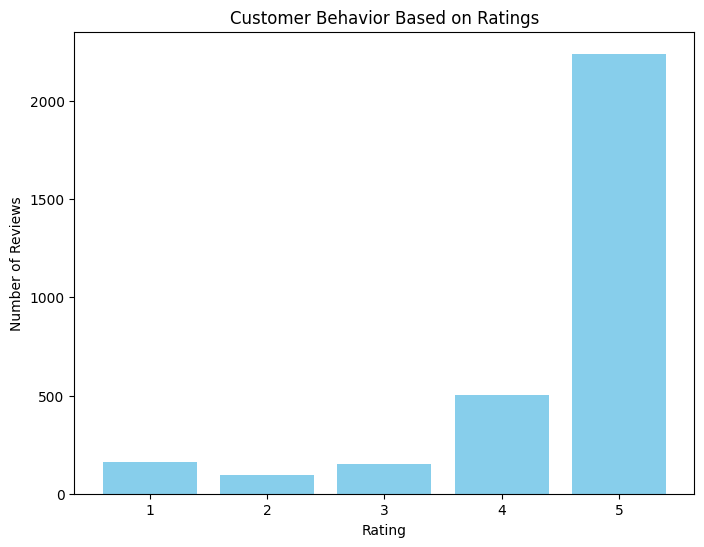

In [8]:
plt.figure(figsize=(8, 6))
plt.bar(rating_counts['rating'], rating_counts['count'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Customer Behavior Based on Ratings')
plt.xticks(rating_counts['rating'])
plt.show()

# Histogram of Ratings

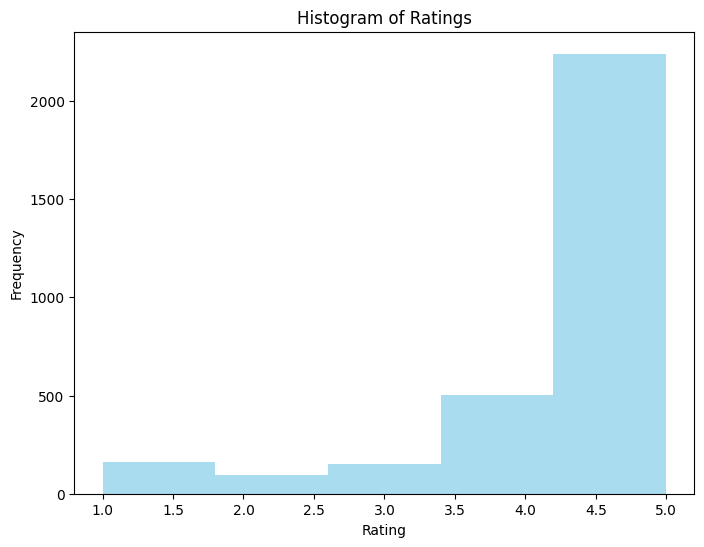

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(pandas_df['rating'], bins=5, color='skyblue', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()


# Pie Chart of Feedback

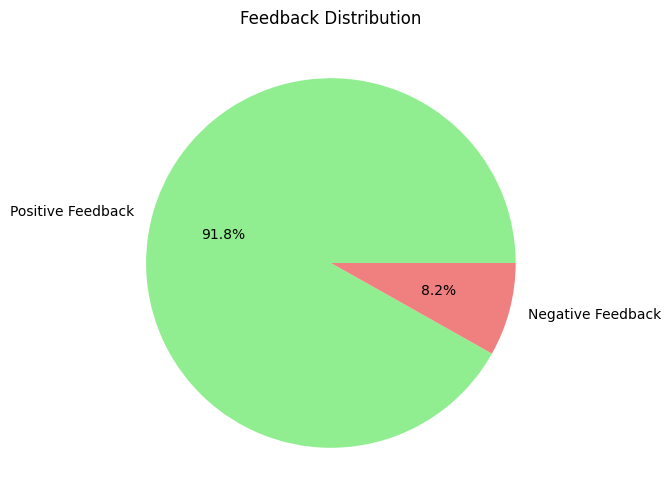

In [10]:
feedback_counts = pandas_df['feedback'].value_counts()
labels = ['Positive Feedback', 'Negative Feedback']
plt.figure(figsize=(8, 6))
plt.pie(feedback_counts, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Feedback Distribution')
plt.show()


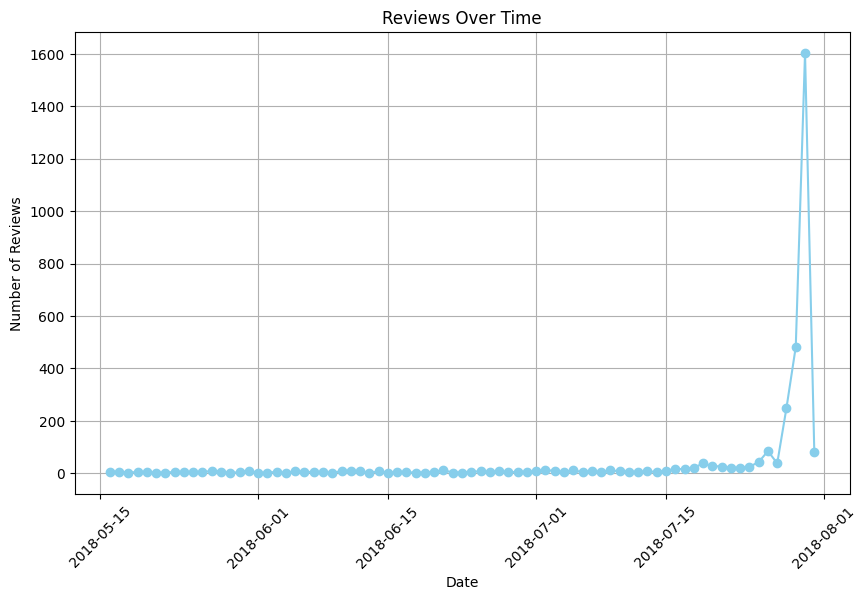

In [22]:
# Converting the 'date' column to datetime objects
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

# Group the data by 'date' and count the number of reviews for each date
time_series_df = pandas_df.groupby('date').size().reset_index(name='count')

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_df['date'], time_series_df['count'], marker='o', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Reviews Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Box Plot of Rating vs. Variation

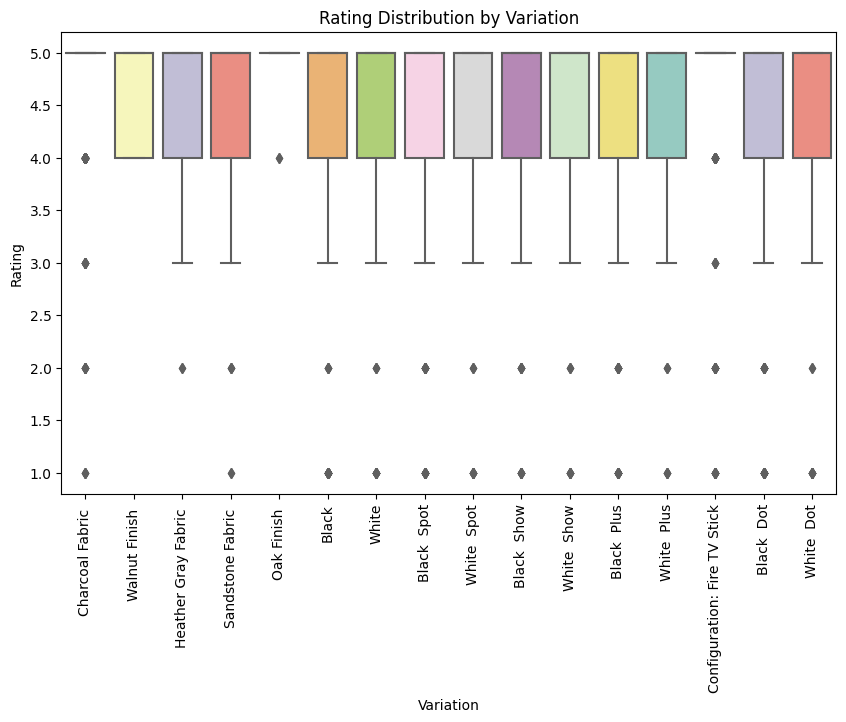

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='rating', data=pandas_df, palette='Set3')
plt.xlabel('Variation')
plt.ylabel('Rating')
plt.title('Rating Distribution by Variation')
plt.xticks(rotation=90)
plt.show()


# Word Cloud of Verified Reviews

In [ ]:
reviews_text = ' '.join(pandas_df['verified_reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Verified Reviews')
plt.show()


In [ ]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(pandas_df['verified_reviews'])
sequences = tokenizer.texts_to_sequences(pandas_df['verified_reviews'])
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')


# Spliting data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, pandas_df['feedback'], test_size=0.2, random_state=42)


# Building an RNN model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


# Compiling and train the model, capturing the training history

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Keeping track of training history using the `history` object

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


Epoch 1/5
40/40 [==============================] - 12s 247ms/step - loss: 0.3425 - accuracy: 0.9004 - val_loss: 0.3048 - val_accuracy: 0.9079
Epoch 2/5
40/40 [==============================] - 7s 187ms/step - loss: 0.2688 - accuracy: 0.9218 - val_loss: 0.2987 - val_accuracy: 0.9111
Epoch 3/5
40/40 [==============================] - 8s 191ms/step - loss: 0.2616 - accuracy: 0.9278 - val_loss: 0.3105 - val_accuracy: 0.9127
Epoch 4/5
40/40 [==============================] - 8s 200ms/step - loss: 0.2558 - accuracy: 0.9302 - val_loss: 0.3020 - val_accuracy: 0.9095
Epoch 5/5
40/40 [==============================] - 6s 157ms/step - loss: 0.2511 - accuracy: 0.9306 - val_loss: 0.3030 - val_accuracy: 0.9079


# Predicting on the test data

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

20/20 [==============================] - 1s 28ms/step


# Calculating evaluation metrics

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.91
Recall: 1.00
F1 Score: 0.95


# Ploting training history (accuracy and loss)

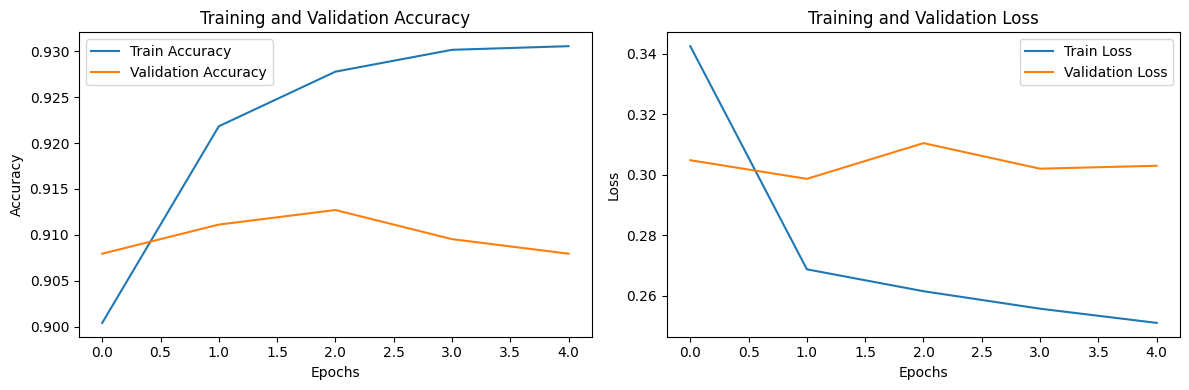

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
